# Past Flares
The goal of this notebook is to explore past flares. Particularly to answer these questions?

- How active is the star?
- Were there flares when SPT was looking but weren't visible in mm?
- Maybe whether flares were observed in other bands?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

from datetime import datetime

Grab identifying data of stars

In [4]:
coinciding_flares_df = pd.read_pickle('spt_tess_candidates.pkl')
names = {'TIC207138379': 'Pike (M4.3)', 'TIC229807000': 'Andes (Binary | M2.5Ve)', 'TIC279255411': 'Matt (Teff:6691 K)', 'TIC401838575': 'Liz (M5.5e)'} # distance in parsecs calculated from parallax from simbdad in mas    
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


In [3]:
hdul = fits.open("spt3g_flare_lightcurves_2019_2022.fits")
hdul.info()

Filename: spt3g_flare_lightcurves_2019_2022.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     33   66R x 9C   [30A, 30A, 30A, 30A, PD(2077), PD(2077), PD(2077), PD(2077), PD(2077)]   


In [4]:
spt_flare_data = hdul[1].data
spt_ids = spt_flare_data.spt_id.astype(str).split('" "')
spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
gaia_ids = np.array(spt_flare_data['gaia_id'])

spt_flux_95 = spt_flare_data['95_flux']
spt_flux_err_95 = spt_flare_data['95_err']
spt_flux_150 = spt_flare_data['150_flux']
spt_flux_err_150 = spt_flare_data['150_err']
spt_mjd = spt_flare_data['mjd']

TIC229807000
SearchResult containing 27 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 01 2018              SPOC     120   229807000      0.0
  1 TESS Sector 28 2020              SPOC      20   229807000      0.0
  2 TESS Sector 27 2020              SPOC      20   229807000      0.0
  3 TESS Sector 28 2020              SPOC     120   229807000      0.0
  4 TESS Sector 27 2020              SPOC     120   229807000      0.0
  5 TESS Sector 67 2023              SPOC      20   229807000      0.0
  6 TESS Sector 68 2023              SPOC      20   229807000      0.0
  7 TESS Sector 68 2023              SPOC     120   229807000      0.0
  8 TESS Sector 67 2023              SPOC     120   229807000      0.0
  9 TESS Sector 01 2018         TESS-SPOC    1800   229807000      0.0
...            ...  .

AttributeError: 'Column' object has no attribute 'columns'

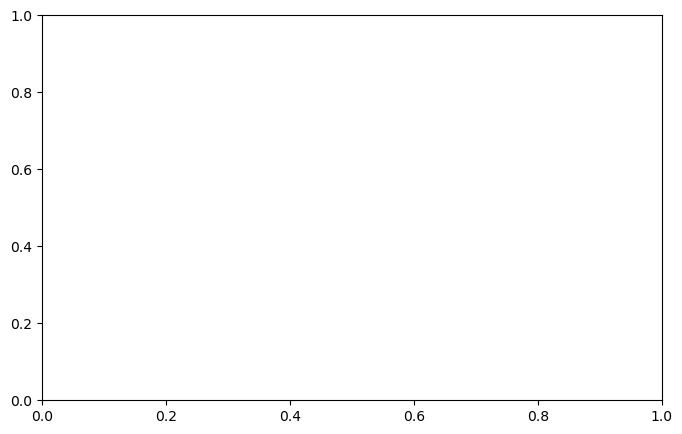

In [8]:
x_lim = {'TIC229807000': 5, 'TIC279255411': 7, 'TIC207138379': 5, 'TIC401838575': 7} # manually picked to remove impact of other transients within a few days or wierd TESS data processing behavior between observations
y_lim_TESS = {'TIC229807000': 6750, 'TIC279255411': 1.45, 'TIC207138379': 1650, 'TIC401838575': 200} # manually picked to scale to flare height
y_lim_SPT = {'TIC229807000': 6750, 'TIC279255411': 1.45, 'TIC207138379': 1650, 'TIC401838575': 200} # manually picked to scale to flare height

for i, flare in coinciding_flares_df.iterrows(): 
    spt_id = flare['spt_id']
    TIC = flare['TIC']
    print(TIC)
    gaia = flare['dr3_source_id']
    idx = np.where(gaia_ids == str(gaia))[0][0]
    f, ax = plt.subplots(1,1,figsize= (8,5))


    '''
    TESS
    '''
    target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
    obj = lk.search_lightcurve(TIC, mission= 'TESS')
    print(obj)

    for i in range(10,58):
        print(i)
        if len(obj['mission'] == f'TESS Sector {i}') == 0: continue
        cur_sector = obj[obj['mission'] == f'TESS Sector {i}']
        flare_obs = cur_sector[0].download()
        print('\t', flare_obs.author, flare_obs.meta)
        qual = flare_obs.quality.value
        time_tdb = Time(flare_obs.time.value[qual == 0], format= flare_obs.time.format, scale= flare_obs.time.scale)
        time = time_tdb.utc.mjd
        cadence = int((time[1] - time[0])*24*3600)
        print("\t exptime:", cadence, 's')
        sap_flux = np.array(flare_obs.sap_flux.value)[qual == 0]

        ax.scatter(time, sap_flux, c= 'c',s= 10, alpha= 0.4, label= f'Sector {i}: {cadence}s)')
    

    '''
    SPT quiescent signal is around 0
    '''
    start_idx = np.where(spt_mjd[idx] >= start_time)[0][0]
    end_idx = np.where(spt_mjd[idx] > end_time)[0][0]
    print('TESS Start:', start_time, '->', start_idx)
    print('TESS End:', end_time, '->', end_idx)

    ax.scatter(spt_mjd[idx], spt_flux_95[idx], c= 'b',marker= 'o', alpha= 0.6, label= 'SPT-3G 95 GHz')
    ax.scatter(spt_mjd[idx], spt_flux_150[idx], c= 'r',marker= '^', alpha= 0.6, label= 'SPT-3G 150 GHz')

    '''
    Plot Formatting
    '''
    ax.set_ylabel('TESS (e-/s) | SPT: (mJy)')
    ax1.set_xlabel('MJD')

    #Close
    # ax2.set_xlim(flare_time - 0.05, flare_time + 0.05)
    # ax1.set_ylim(None,y_lim_TESS[TIC])
    #Medium
    # ax2.set_xlim(flare_time - 0.15, flare_time + 0.15)    
    #Large
    # ax2.set_xlim(flare_time - x_lim[TIC], flare_time + x_lim[TIC])

    ax.set_title(names[TIC])
    f.show()
    